In [1]:
!pip install seqeval

In [2]:
#!wget http://vectors.nlpl.eu/repository/20/6.zip

In [3]:
#!unzip /content/6.zip

In [4]:
from typing import List
import re
import string
import math
import os

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain

from tqdm.notebook import tqdm_notebook

from sklearn.model_selection import train_test_split
# import skmultilearn
from nltk.tokenize import word_tokenize
# from pandarallel import pandarallel
import pickle as pkl
from argparse import Namespace

import gensim
from gensim.test.utils import datapath

import gc

In [5]:
#!unzip 6.zip -d wikipedia
word2vec_weights = gensim.models.KeyedVectors.load_word2vec_format('wikipedia/model.txt')

In [6]:
train_data_path = 'hw1_train.csv'
train_data = pd.read_csv(train_data_path)

In [7]:
df = pd.read_csv(train_data_path)
df['IOB Slot tags'] = df['IOB Slot tags'].replace(np.nan, "none")

In [8]:
item_list = list(row.to_dict() for idx, row in df.iterrows())
np.random.shuffle(item_list)
item_list = [item for item in item_list if len(item['utterances'].split(' ')) == len(item['IOB Slot tags'].split(' '))]

In [9]:
train_df, validation_df = train_test_split(item_list, test_size=0.1, train_size=0.9)

In [10]:
class VocabularyEmbedding(object):
    def __init__(self, gensim_w2v):

        self.w2v = gensim_w2v
        self.w2v.add_vector('<s>', np.random.uniform(low=-1, high=1.0, size=(300,)))
        self.w2v.add_vector('</s>', np.random.uniform(low=-1, high=1.0, size=(300,)))
        self.w2v.add_vector('<pad>', np.random.uniform(low=-1, high=1.0, size=(300,)))
        self.w2v.add_vector('<unk>', np.random.uniform(low=-1, high=1.0, size=(300,)))

        bos = self.w2v.key_to_index.get('<s>')
        eos = self.w2v.key_to_index.get('</s>')
        pad = self.w2v.key_to_index.get('<pad>')
        unk = self.w2v.key_to_index.get('<unk>')

        self.bos_index = bos
        self.eos_index = eos
        self.pad_index = pad
        self.unk_index = unk


    def tokenizer(self, text):
        return [t for t in text.split(' ')]

    def encode(self, text):

        sequence = []

        tokens = self.tokenizer(text)
        for token in tokens:

            index = self.w2v.key_to_index.get(token, self.unk_index)
            sequence.append(index)

        return sequence

    def create_padded_tensor(self, sequences):

        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token

        return tensor, lengths

In [11]:
class BIOTagSequencer(object):
    def __init__(self, tag_corpus, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}
        self.unk_index = self.add_token(unk_token)
        self.pad_index = self.add_token(pad_token)
        self.bos_index = self.add_token(bos_token)
        self.eos_index = self.add_token(eos_token)
        self.tokenizer = lambda text: [t for t in text.split(' ')]

        for _tags in tag_corpus:
          for _token in self.tokenizer(_tags):
            self.add_token(_token)

    def add_token(self, token):
        if token not in self.word2idx:
          self.word2idx[token] = new_index = len(self.word2idx)
          self.idx2word[new_index] = token
          return new_index

        else:
          return self.word2idx[token]

    def encode(self, text):
        tokens = self.tokenizer(text)

        sequence = []

        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)

        return sequence

    def create_padded_tensor(self, sequences):

        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token

        return tensor, lengths

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch

class CoreRelationSequencer:
    def __init__(self, relation_corpus):
        self.mlb = MultiLabelBinarizer()
        relations = [set(relation.split()) for relation in relation_corpus]
        self.mlb.fit(relations)

    def encode(self, relation_string):
        relations = set(relation_string.split())
        encoded = self.mlb.transform([relations])
        return encoded[0]

    def decode(self, encoded_vector):
        relations = self.mlb.inverse_transform(np.array([encoded_vector]))
        return ' '.join(relations[0])

    def output_size(self):
        """Return the number of unique core relations (the size of the one-hot encoded vector)."""
        return len(self.mlb.classes_)

    def create_padded_tensor(self, sequences):
        max_seq_len = max(len(seq) for seq in sequences)
        num_classes = len(self.mlb.classes_)

        # Initialize a tensor of zeros
        tensor = torch.zeros((len(sequences), max_seq_len, num_classes), dtype=torch.float)

        for i, sequence in enumerate(sequences):
            encoded_seq = self.encode(sequence)
            seq_len = len(encoded_seq)

            # Assign the one-hot encoded sequence to the tensor
            tensor[i, :seq_len, :] = torch.tensor(encoded_seq, dtype=torch.float)

        return tensor

In [13]:
# class TaggerDataset(Dataset):
#     def __init__(self, data, text_sequencer, tag_sequencer):

#         self.data = data

#         self.input_sequencer = text_sequencer

#         self.out_sequencer = tag_sequencer

#     def __getitem__(self, index):
#         text, tags = self.data[index]

#         x = self.input_sequencer.encode(text)
#         y = self.out_sequencer.encode(tags)

#         return x, y

#     def __len__(self):
#         return len(self.data)

In [14]:
class TaggerDataset(Dataset):
    def __init__(self, data, text_sequencer, core_sequencer, bio_sequencer):

        self.data = data

        self.input_sequencer = text_sequencer

        self.core_sequencer = core_sequencer
        self.bio_sequencer = bio_sequencer

    def __getitem__(self, index):
        text, core_tags, bio_tags = self.data[index]

        x = self.input_sequencer.encode(text)
        y = self.core_sequencer.encode(core_tags)
        z = self.bio_sequencer.encode(bio_tags)

        return x, y, z

    def __len__(self):
        return len(self.data)

In [15]:
# class TransformerEncoder(nn.Module):
#     def __init__(self, d_model=64, n_heads=4, d_hidden=256, n_layers=4, p_dropout=0.0, vocab_size=1000):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, d_model)

#         # Define the transformer encoder layer
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model,
#             nhead=n_heads,
#             dim_feedforward=d_hidden,
#             dropout=p_dropout
#         )

#         # Stack multiple layers
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

#     def forward(self, tokens, pad_mask):
#         # Assuming 'tokens' is the input tensor to your model
#         print("Max token index:", torch.max(tokens))
#         print("Min token index:", torch.min(tokens))
#         print("Embedding layer vocabulary size:", model.embedding.num_embeddings)
#         x = self.embedding(tokens)
#         x = self.transformer_encoder(x, src_key_padding_mask=pad_mask)

#         return x


In [16]:
import torch
import torch.nn as nn

class Transformer_Model(nn.Module):
    def __init__(self, core_output_size, bio_output_size, pad_index, d_model=300, n_heads=4, d_hidden=256, n_layers=2, dropout_p=0.1, w2v_weights=word2vec_weights):
        super(Transformer_Model, self).__init__()
        self.pad_index = pad_index

        # tunable embeddings
        self.embedding = nn.Embedding.from_pretrained(w2v_weights, freeze=False)

        # frozen embeddings
        self.frozen_embedding = nn.Embedding.from_pretrained(w2v_weights, freeze=True)

        self.dropout = nn.Dropout(dropout_p)

        # Define the transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_hidden,
            dropout=dropout_p
        )

        # Stack multiple layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Final linear layer
        self.core_fc = nn.Linear(d_model, core_output_size, bias=False)
        self.bio_fc = nn.Linear(d_model, bio_output_size, bias=False)


    def forward(self, x, lengths):
        # Create a mask for padding
        pad_mask = (x == self.pad_index)#.transpose(0, 1)

        # Embeddings
        embed = self.embedding(x)
        embed_frozen = self.frozen_embedding(x)

        # Combine embeddings
        #embed_combined = self.dropout(torch.cat((embed, embed_frozen), dim=2))
        embed_combined = self.dropout(embed)

        # Adjust dimensions for Transformer
        embed_combined = embed_combined.permute(1, 0, 2)  # Shape: [seq_len, batch_size, d_model]

        # Transformer Encoder
        transformer_output = self.transformer_encoder(embed_combined, src_key_padding_mask=pad_mask)

        # Permute back to [batch_size, seq_len, d_model]
        transformer_output = transformer_output.permute(1, 0, 2)

        # Apply final linear layers for core and bio
        core_logits = self.core_fc(transformer_output).mean(dim=1)
        bio_logits = self.bio_fc(transformer_output)

        return core_logits, bio_logits


In [17]:
# Convert train_df and validation_df back to DataFrames
train_df = pd.DataFrame(train_df)
validation_df = pd.DataFrame(validation_df)

# Replace NaN values in the Core Relations column with a placeholder string
train_df['Core Relations'] = train_df['Core Relations'].fillna("none")
validation_df['Core Relations'] = validation_df['Core Relations'].fillna("none")


In [18]:
# train_data = [(i['utterances'], i['Core Relations'], i['IOB Slot tags']) for i in train_df]

# val_data = [(i['utterances'], i['Core Relations'], i['IOB Slot tags']) for i in validation_df]

# Assuming 'relation_corpus' is a list of all core relation strings from your dataset
relation_corpus = [row['Core Relations'] for index, row in train_df.iterrows()]


train_data = [(row['utterances'], row['Core Relations'], row['IOB Slot tags']) for index, row in train_df.iterrows()]
val_data = [(row['utterances'], row['Core Relations'], row['IOB Slot tags']) for index, row in validation_df.iterrows()]

train_texts = list([e[0] for e in train_data])
train_core_tags = list([e[1] for e in train_data])
train_bio_tags = list([e[2] for e in train_data])

text_sequencer = VocabularyEmbedding(word2vec_weights)
core_sequencer = CoreRelationSequencer(relation_corpus)
bio_sequencer = BIOTagSequencer(train_bio_tags)

train_dataset = TaggerDataset(train_data, text_sequencer, core_sequencer, bio_sequencer)
val_dataset = TaggerDataset(val_data, text_sequencer, core_sequencer, bio_sequencer)

def prepare_batch(batch, in_sequencer, core_sequencer, bio_sequencer):
    texts, core_labels, bio_labels = zip(*batch)
    text_tensor, lengths = in_sequencer.create_padded_tensor(texts)

    # Check if core_labels need encoding
    if isinstance(core_labels[0], str):
        core_tensor = core_sequencer.create_padded_tensor(core_labels)
    else:
        # If already one-hot encoded, just convert to tensor
        core_tensor = torch.tensor(core_labels, dtype=torch.float)

    bio_tensor, _ = bio_sequencer.create_padded_tensor(bio_labels)
    #print("Core tensor shape:", core_tensor.shape)
    #print("Bio tensor shape:", bio_tensor.shape)
    return (text_tensor, lengths, core_tensor, bio_tensor)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, core_sequencer, bio_sequencer))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, core_sequencer, bio_sequencer), shuffle=False)

hidden_size=10
core_output_size = core_sequencer.output_size()
bio_output_size = len(bio_sequencer.idx2word)
pad_index = bio_sequencer.pad_index

#print("Core output size:", core_output_size)
#print("BIO output size:", bio_output_size)

w2v_weights_array = word2vec_weights.vectors
w2v_weights_tensor = torch.tensor(w2v_weights_array, dtype=torch.float)


model = Transformer_Model(core_output_size, bio_output_size, pad_index, w2v_weights=w2v_weights_tensor)


learning_rate = 1e-3
core_loss_function = nn.BCEWithLogitsLoss() # Avoid computing loss on padding tokens
bio_loss_function = nn.CrossEntropyLoss(ignore_index=bio_sequencer.pad_index) # Avoid computing loss on padding tokens
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/detrived/miniconda3/lib/python3.11/site-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(
/home/detrived/miniconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [19]:
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# from torch.nn import functional as F
# from tqdm import tqdm

# def train(model, optimizer, core_loss_function, bio_loss_function, loader, core_labels, bio_labels, log_every_n=100):
#     model.train()

#     total_loss = 0
#     for i, batch in enumerate(tqdm(loader, desc="Training")):
#         optimizer.zero_grad()

#         # Get inputs from the batch
#         inputs, lengths, core_targets, bio_targets = batch

#         # Forward pass: Get core and bio logits from the model
#         core_logits, bio_logits = model(batch[0], batch[1])
#         core_targets = batch[2].view_as(core_logits)


#         # Compute loss for each set of logits
#         #print("Core logits:", core_logits.shape)
#         #print("BIO logits:", bio_logits.shape)
#         core_loss = core_loss_function(core_logits, core_targets)
#         #core_loss = core_loss_function(core_logits.view(-1, core_logits.size(-1)), core_targets.view(-1))
#         bio_loss = bio_loss_function(bio_logits.view(-1, bio_logits.size(-1)), bio_targets.view(-1))

#         # Combine losses (summing up in this example)
#         combined_loss = core_loss + bio_loss
#         total_loss += combined_loss.item()

#         # Backward pass and optimization
#         combined_loss.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
#         optimizer.step()

#         # Optionally log the loss
#         if log_every_n > 0 and (i + 1) % log_every_n == 0:
#             print(f"Batch {i + 1}: Combined Loss = {total_loss / (i + 1)}")

#     return combined_loss, (total_loss / len(loader))


In [20]:
from sklearn.metrics import classification_report
from seqeval.metrics import classification_report as seqeval_report
from seqeval.scheme import IOB2
import numpy as np
from tqdm import tqdm

def train(model, optimizer, core_loss_function, bio_loss_function, loader, core_labels, bio_labels, log_every_n=100):
    model.train()

    total_loss = 0
    all_core_preds = []
    all_core_true = []
    all_bio_preds = []
    all_bio_true = []

    for i, batch in enumerate(tqdm(loader, desc="Training")):
        optimizer.zero_grad()

        # Get inputs and targets from the batch
        inputs, lengths, core_targets, bio_targets = batch

        # Forward pass: Get core and bio logits from the model
        core_logits, bio_logits = model(inputs, lengths)
        core_targets = core_targets.view_as(core_logits)

        # Compute loss for each set of logits
        core_loss = core_loss_function(core_logits, core_targets)
        bio_loss = bio_loss_function(bio_logits.view(-1, bio_logits.size(-1)), bio_targets.view(-1))

        # Combine losses
        combined_loss = core_loss + bio_loss
        total_loss += combined_loss.item()

        # Backward pass and optimization
        combined_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        optimizer.step()

        # Collect predictions and true labels for metrics calculation
        all_core_preds.extend(core_logits.sigmoid().round().detach().cpu().numpy())
        all_core_true.extend(core_targets.detach().cpu().numpy())

        bio_preds = torch.argmax(bio_logits, -1).detach().cpu().numpy()
        bio_true = bio_targets.detach().cpu().numpy()
        for bp, bt in zip(bio_preds, bio_true):
            all_bio_preds.append([bio_labels[label] for label in bp])
            all_bio_true.append([bio_labels[label] for label in bt])

        # Optionally log the loss
        if log_every_n > 0 and (i + 1) % log_every_n == 0:
            print(f"Batch {i + 1}: Combined Loss = {total_loss / (i + 1)}")

    # Flatten core predictions and true labels for classification report
    flat_core_preds = np.argmax(all_core_preds, axis=1)
    flat_core_true = np.argmax(all_core_true, axis=1)

    # Print classification report for core relations
    print("Core Relation Classification Report:")
    print(classification_report(flat_core_true, flat_core_preds, target_names=core_labels))

    # Print classification report for BIO tagging
    print("BIO Tagging Report:")
    print(seqeval_report(all_bio_true, all_bio_preds, scheme=IOB2))

    return combined_loss, (total_loss / len(loader))


In [23]:
def run_training(model, optimizer, core_loss_function, bio_loss_function, train_loader, valid_loader, core_labels, bio_labels, n_epochs=20):
        train_losses = []
        train_running_losses = []

        valid_losses = []
        valid_running_losses = []

        for i in range(n_epochs):
            print(f"Epoch: {i}")
            train_loss_history, train_running_loss_history = train(model, optimizer, core_loss_function, bio_loss_function, train_loader, core_labels, bio_labels, log_every_n=100)
            train_losses.append(train_loss_history)
            train_running_losses.append(train_running_loss_history)

            # val_loss_history, val_running_loss_history = train(model, optimizer, core_loss_function, bio_loss_function, valid_loader, core_labels, bio_labels, log_every_n=100)
            # valid_losses.append(val_loss_history)
            # valid_running_losses.append(val_running_loss_history)

        #all_train_losses = list(chain.from_iterable(train_losses))
        #all_train_running_losses = list(chain.from_iterable(train_running_losses))

        #train_epoch_idx = range(len(all_train_running_losses))


        return train_losses, train_running_losses, valid_losses, valid_running_losses

In [24]:
core_label_list = list(core_sequencer.mlb.classes_)
bio_label_list = [bio_sequencer.idx2word[i] for i in range(len(bio_sequencer.idx2word))]
train_losses, train_running_losses, valid_losses, valid_running_losses = run_training(model, optimizer, core_loss_function, bio_loss_function, train_loader, val_loader, core_label_list, bio_label_list, n_epochs=10)

Epoch: 0


Training: 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      1.00      0.01         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       208
         movie.directed_by       0.00      0.00      0.00       293
    movie.estimated_budget       0.00      0.00      0.00        62
               movie.genre       0.00      0.00      0.00       100
       movie.gross_revenue       0.00      0.00      0.00        22
movie.initial_release_date       0.00      0.00      0.00       155
            movie.language       0.33      0.02      0.05       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.00      0.00      0.00       157
movie.production_companies       0.00      0.00      0.00        78
          

Training: 100%|██████████| 64/64 [00:23<00:00,  2.68it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.86      0.01         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.71      0.08      0.15       208
         movie.directed_by       0.90      0.35      0.51       293
    movie.estimated_budget       0.00      0.00      0.00        62
               movie.genre       1.00      0.01      0.02       100
       movie.gross_revenue       0.00      0.00      0.00        22
movie.initial_release_date       1.00      0.23      0.37       155
            movie.language       0.64      0.52      0.58       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.82      0.31      0.45       157
movie.production_companies       0.00      0.00      0.00        78
          

Training: 100%|██████████| 64/64 [00:24<00:00,  2.58it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.14      0.00         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.61      0.26      0.36       208
         movie.directed_by       0.91      0.71      0.80       293
    movie.estimated_budget       0.94      0.53      0.68        62
               movie.genre       0.87      0.45      0.59       100
       movie.gross_revenue       1.00      0.09      0.17        22
movie.initial_release_date       1.00      0.59      0.74       155
            movie.language       0.73      0.58      0.65       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.81      0.83      0.82       157
movie.production_companies       0.00      0.00      0.00        78
          

Training: 100%|██████████| 64/64 [00:25<00:00,  2.47it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.14      0.00         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.75      0.44      0.56       208
         movie.directed_by       0.93      0.75      0.83       293
    movie.estimated_budget       0.89      0.79      0.84        62
               movie.genre       0.94      0.72      0.81       100
       movie.gross_revenue       1.00      0.23      0.37        22
movie.initial_release_date       0.99      0.69      0.81       155
            movie.language       0.80      0.74      0.77       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.81      0.87      0.84       157
movie.production_companies       0.88      0.09      0.16        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.16      0.20      0.18        98
        _char       0.20      0.21      0.21        14
     _country       0.20      0.46      0.28       144
    _director       0.05      0.11      0.07       161
       _genre       0.38      0.92      0.53        60
    _language       0.69      0.89      0.78       107
    _location       0.00      0.00      0.00         2
       _movie       0.26      0.59      0.36       891
 _mpaa_rating       0.18      0.50      0.27       124
      _person       0.07      0.14      0.10       154
    _producer       0.09      0.31      0.14       154
_release_year       0.60      0.75      0.67         4
     _subject       0.80      0.94      0.86        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.23      0.25      0.24      3945
    macro avg       0.25      0.40      0.30      3945
 weighte

Training: 100%|██████████| 64/64 [00:25<00:00,  2.46it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.00      0.00         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.76      0.58      0.66       208
         movie.directed_by       0.92      0.80      0.85       293
    movie.estimated_budget       0.95      0.87      0.91        62
               movie.genre       0.92      0.85      0.89       100
       movie.gross_revenue       0.93      0.59      0.72        22
movie.initial_release_date       0.99      0.81      0.89       155
            movie.language       0.86      0.79      0.82       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.85      0.87      0.86       157
movie.production_companies       0.88      0.27      0.41        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.10      0.18      0.13        98
        _char       0.08      0.29      0.12        14
     _country       0.12      0.49      0.19       144
    _director       0.07      0.17      0.10       161
       _genre       0.35      0.93      0.51        60
    _language       0.55      0.87      0.67       107
    _location       0.00      0.00      0.00         2
       _movie       0.31      0.62      0.41       891
 _mpaa_rating       0.17      0.55      0.26       124
      _person       0.07      0.17      0.10       154
    _producer       0.10      0.30      0.15       154
_release_year       1.00      0.75      0.86         4
     _subject       0.51      0.94      0.66        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.22      0.26      0.24      3945
    macro avg       0.23      0.42      0.28      3945
 weighte

Training: 100%|██████████| 64/64 [00:26<00:00,  2.46it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.00      0.00         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.80      0.64      0.71       208
         movie.directed_by       0.92      0.81      0.86       293
    movie.estimated_budget       0.95      0.92      0.93        62
               movie.genre       0.95      0.88      0.91       100
       movie.gross_revenue       0.94      0.68      0.79        22
movie.initial_release_date       0.95      0.85      0.90       155
            movie.language       0.88      0.82      0.85       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.84      0.88      0.86       157
movie.production_companies       0.86      0.32      0.47        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.11      0.26      0.15        98
        _char       0.07      0.36      0.12        14
     _country       0.14      0.53      0.22       144
    _director       0.05      0.16      0.07       161
       _genre       0.26      0.92      0.40        60
    _language       0.52      0.89      0.66       107
    _location       0.00      0.00      0.00         2
       _movie       0.32      0.66      0.43       891
 _mpaa_rating       0.16      0.58      0.25       124
      _person       0.06      0.20      0.10       154
    _producer       0.10      0.32      0.15       154
_release_year       0.75      0.75      0.75         4
     _subject       0.53      0.90      0.67        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.21      0.28      0.24      3945
    macro avg       0.20      0.43      0.26      3945
 weighte

Training: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.00      0.00         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.85      0.67      0.75       208
         movie.directed_by       0.93      0.84      0.88       293
    movie.estimated_budget       0.98      0.94      0.96        62
               movie.genre       0.95      0.89      0.92       100
       movie.gross_revenue       0.85      0.77      0.81        22
movie.initial_release_date       0.95      0.90      0.92       155
            movie.language       0.91      0.86      0.89       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.88      0.94      0.91       157
movie.production_companies       0.89      0.42      0.57        78
          

Training: 100%|██████████| 64/64 [00:24<00:00,  2.64it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.00      0.00         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.84      0.70      0.77       208
         movie.directed_by       0.91      0.84      0.88       293
    movie.estimated_budget       0.98      0.95      0.97        62
               movie.genre       0.94      0.88      0.91       100
       movie.gross_revenue       0.81      0.77      0.79        22
movie.initial_release_date       0.96      0.90      0.93       155
            movie.language       0.92      0.85      0.88       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.88      0.96      0.92       157
movie.production_companies       0.89      0.41      0.56        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.10      0.18      0.13        98
        _char       0.15      0.43      0.23        14
     _country       0.12      0.54      0.20       144
    _director       0.04      0.16      0.06       161
       _genre       0.37      0.93      0.53        60
    _language       0.32      0.92      0.47       107
    _location       0.00      0.00      0.00         2
       _movie       0.29      0.67      0.41       891
 _mpaa_rating       0.14      0.56      0.23       124
      _person       0.07      0.22      0.11       154
    _producer       0.10      0.31      0.15       154
_release_year       1.00      1.00      1.00         4
     _subject       0.53      0.92      0.67        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.20      0.28      0.23      3945
    macro avg       0.22      0.46      0.28      3945
 weighte

Training: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.01      0.29      0.02         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.86      0.73      0.79       208
         movie.directed_by       0.93      0.84      0.88       293
    movie.estimated_budget       0.98      0.94      0.96        62
               movie.genre       0.98      0.92      0.95       100
       movie.gross_revenue       0.84      0.73      0.78        22
movie.initial_release_date       0.96      0.92      0.94       155
            movie.language       0.96      0.90      0.93       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.88      0.93      0.91       157
movie.production_companies       0.93      0.47      0.63        78
          

Training: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.00      0.00         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.88      0.77      0.82       208
         movie.directed_by       0.92      0.85      0.88       293
    movie.estimated_budget       0.97      0.95      0.96        62
               movie.genre       0.96      0.93      0.94       100
       movie.gross_revenue       0.83      0.86      0.84        22
movie.initial_release_date       0.96      0.92      0.94       155
            movie.language       0.97      0.93      0.95       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.88      0.96      0.92       157
movie.production_companies       0.89      0.51      0.65        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.11      0.20      0.15        98
        _char       0.15      0.43      0.23        14
     _country       0.13      0.57      0.21       144
    _director       0.03      0.16      0.06       161
       _genre       0.85      0.97      0.91        60
    _language       0.37      0.93      0.53       107
    _location       0.00      0.00      0.00         2
       _movie       0.35      0.69      0.46       891
 _mpaa_rating       0.16      0.60      0.25       124
      _person       0.07      0.21      0.10       154
    _producer       0.12      0.38      0.19       154
_release_year       1.00      1.00      1.00         4
     _subject       0.59      0.93      0.72        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.22      0.29      0.25      3945
    macro avg       0.26      0.47      0.32      3945
 weighte

Training: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.02      0.43      0.04         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.86      0.77      0.81       208
         movie.directed_by       0.93      0.85      0.88       293
    movie.estimated_budget       0.98      0.97      0.98        62
               movie.genre       0.96      0.91      0.93       100
       movie.gross_revenue       0.87      0.91      0.89        22
movie.initial_release_date       0.96      0.96      0.96       155
            movie.language       0.96      0.90      0.93       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.88      0.93      0.90       157
movie.production_companies       0.85      0.53      0.65        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.10      0.21      0.13        98
        _char       0.12      0.36      0.19        14
     _country       0.13      0.56      0.21       144
    _director       0.04      0.18      0.07       161
       _genre       0.92      0.92      0.92        60
    _language       0.22      0.91      0.36       107
    _location       0.00      0.00      0.00         2
       _movie       0.33      0.70      0.45       891
 _mpaa_rating       0.14      0.60      0.23       124
      _person       0.07      0.25      0.12       154
    _producer       0.13      0.37      0.19       154
_release_year       1.00      1.00      1.00         4
     _subject       0.60      0.92      0.73        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.21      0.29      0.24      3945
    macro avg       0.25      0.46      0.30      3945
 weighte

Training: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.01      0.29      0.02         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.89      0.77      0.82       208
         movie.directed_by       0.91      0.85      0.87       293
    movie.estimated_budget       0.98      0.98      0.98        62
               movie.genre       0.98      0.94      0.96       100
       movie.gross_revenue       0.88      0.95      0.91        22
movie.initial_release_date       0.95      0.93      0.94       155
            movie.language       0.99      0.90      0.94       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.89      0.94      0.91       157
movie.production_companies       0.89      0.53      0.66        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.10      0.22      0.14        98
        _char       0.26      0.50      0.34        14
     _country       0.20      0.58      0.30       144
    _director       0.05      0.16      0.08       161
       _genre       0.80      0.93      0.86        60
    _language       0.24      0.93      0.38       107
    _location       0.00      0.00      0.00         2
       _movie       0.34      0.67      0.46       891
 _mpaa_rating       0.22      0.58      0.32       124
      _person       0.09      0.22      0.13       154
    _producer       0.11      0.35      0.16       154
_release_year       0.50      0.50      0.50         4
     _subject       0.62      0.93      0.74        83
        movie       1.00      1.00      1.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.24      0.29      0.26      3945
    macro avg       0.30      0.51      0.36      3945
 weighte

Training: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.02      0.43      0.04         7
                 gr.amount       0.00      0.00      0.00         3
             movie.country       0.86      0.77      0.81       208
         movie.directed_by       0.92      0.85      0.88       293
    movie.estimated_budget       1.00      0.98      0.99        62
               movie.genre       0.98      0.91      0.94       100
       movie.gross_revenue       0.87      0.91      0.89        22
movie.initial_release_date       0.95      0.91      0.93       155
            movie.language       0.97      0.89      0.93       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.92      0.96      0.94       157
movie.production_companies       0.81      0.50      0.62        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.06      0.17      0.08        98
        _char       0.15      0.50      0.23        14
     _country       0.16      0.60      0.25       144
    _director       0.06      0.25      0.09       161
       _genre       0.83      0.97      0.89        60
    _language       0.35      0.93      0.51       107
    _location       0.00      0.00      0.00         2
       _movie       0.37      0.66      0.47       891
 _mpaa_rating       0.19      0.56      0.28       124
      _person       0.09      0.23      0.13       154
    _producer       0.12      0.35      0.18       154
_release_year       1.00      1.00      1.00         4
     _subject       0.64      0.95      0.77        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.23      0.29      0.26      3945
    macro avg       0.27      0.48      0.33      3945
 weighte

Training: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.02      0.57      0.04         7
                 gr.amount       1.00      0.33      0.50         3
             movie.country       0.88      0.76      0.82       208
         movie.directed_by       0.92      0.83      0.87       293
    movie.estimated_budget       0.98      0.98      0.98        62
               movie.genre       0.98      0.93      0.95       100
       movie.gross_revenue       0.91      0.91      0.91        22
movie.initial_release_date       0.97      0.94      0.96       155
            movie.language       0.96      0.90      0.93       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.91      0.93      0.92       157
movie.production_companies       0.91      0.53      0.67        78
          

Training: 100%|██████████| 64/64 [00:25<00:00,  2.46it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.01      0.29      0.02         7
                 gr.amount       1.00      0.33      0.50         3
             movie.country       0.89      0.76      0.82       208
         movie.directed_by       0.91      0.84      0.87       293
    movie.estimated_budget       0.98      0.97      0.98        62
               movie.genre       0.98      0.95      0.96       100
       movie.gross_revenue       0.90      0.86      0.88        22
movie.initial_release_date       0.93      0.92      0.93       155
            movie.language       0.97      0.93      0.95       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.89      0.94      0.91       157
movie.production_companies       0.83      0.56      0.67        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.09      0.22      0.13        98
        _char       0.15      0.43      0.22        14
     _country       0.17      0.57      0.26       144
    _director       0.05      0.20      0.08       161
       _genre       0.88      0.97      0.92        60
    _language       0.34      0.93      0.50       107
    _location       1.00      0.50      0.67         2
       _movie       0.38      0.70      0.49       891
 _mpaa_rating       0.21      0.57      0.30       124
      _person       0.08      0.26      0.12       154
    _producer       0.15      0.40      0.22       154
_release_year       0.75      0.75      0.75         4
     _subject       0.69      0.94      0.80        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.25      0.30      0.27      3945
    macro avg       0.33      0.50      0.36      3945
 weighte

Training: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.04      0.86      0.07         7
                 gr.amount       1.00      1.00      1.00         3
             movie.country       0.85      0.77      0.81       208
         movie.directed_by       0.94      0.86      0.90       293
    movie.estimated_budget       1.00      0.98      0.99        62
               movie.genre       0.99      0.94      0.96       100
       movie.gross_revenue       1.00      0.95      0.98        22
movie.initial_release_date       0.96      0.95      0.95       155
            movie.language       0.97      0.88      0.93       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.91      0.92      0.91       157
movie.production_companies       0.88      0.54      0.67        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.11      0.22      0.15        98
        _char       0.13      0.50      0.21        14
     _country       0.17      0.54      0.26       144
    _director       0.05      0.20      0.08       161
       _genre       0.72      0.93      0.81        60
    _language       0.39      0.91      0.54       107
    _location       0.00      0.00      0.00         2
       _movie       0.35      0.71      0.47       891
 _mpaa_rating       0.20      0.60      0.30       124
      _person       0.08      0.26      0.12       154
    _producer       0.13      0.39      0.19       154
_release_year       1.00      1.00      1.00         4
     _subject       0.71      0.93      0.81        83
        movie       0.00      0.00      0.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.24      0.30      0.27      3945
    macro avg       0.27      0.48      0.33      3945
 weighte

Training: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.03      0.57      0.06         7
                 gr.amount       1.00      0.67      0.80         3
             movie.country       0.85      0.78      0.82       208
         movie.directed_by       0.92      0.87      0.90       293
    movie.estimated_budget       1.00      1.00      1.00        62
               movie.genre       0.99      0.91      0.95       100
       movie.gross_revenue       0.96      1.00      0.98        22
movie.initial_release_date       0.96      0.92      0.94       155
            movie.language       0.96      0.93      0.94       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.90      0.95      0.92       157
movie.production_companies       0.87      0.59      0.70        78
          

/home/detrived/miniconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        _cast       0.09      0.24      0.13        98
        _char       0.11      0.43      0.17        14
     _country       0.22      0.56      0.31       144
    _director       0.06      0.19      0.09       161
       _genre       0.87      0.97      0.91        60
    _language       0.48      0.91      0.62       107
    _location       0.00      0.00      0.00         2
       _movie       0.35      0.71      0.47       891
 _mpaa_rating       0.22      0.59      0.32       124
      _person       0.06      0.21      0.09       154
    _producer       0.12      0.36      0.19       154
_release_year       1.00      1.00      1.00         4
     _subject       0.70      0.94      0.80        83
        movie       1.00      1.00      1.00         1
         pad>       0.00      0.00      0.00      1948

    micro avg       0.25      0.30      0.27      3945
    macro avg       0.35      0.54      0.41      3945
 weighte

Training: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.03      0.57      0.05         7
                 gr.amount       1.00      0.67      0.80         3
             movie.country       0.90      0.76      0.83       208
         movie.directed_by       0.93      0.85      0.89       293
    movie.estimated_budget       1.00      0.98      0.99        62
               movie.genre       0.97      0.94      0.95       100
       movie.gross_revenue       0.96      1.00      0.98        22
movie.initial_release_date       0.98      0.96      0.97       155
            movie.language       0.97      0.92      0.94       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.90      0.94      0.92       157
movie.production_companies       0.90      0.55      0.68        78
          

Training: 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.05      1.00      0.09         7
                 gr.amount       1.00      0.67      0.80         3
             movie.country       0.91      0.78      0.84       208
         movie.directed_by       0.93      0.86      0.90       293
    movie.estimated_budget       1.00      0.98      0.99        62
               movie.genre       0.99      0.94      0.96       100
       movie.gross_revenue       0.96      1.00      0.98        22
movie.initial_release_date       0.96      0.95      0.96       155
            movie.language       0.97      0.93      0.95       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.91      0.94      0.92       157
movie.production_companies       0.94      0.58      0.71        78
          

Training: 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.06      1.00      0.11         7
                 gr.amount       1.00      1.00      1.00         3
             movie.country       0.86      0.81      0.83       208
         movie.directed_by       0.93      0.87      0.90       293
    movie.estimated_budget       1.00      1.00      1.00        62
               movie.genre       0.98      0.92      0.95       100
       movie.gross_revenue       1.00      1.00      1.00        22
movie.initial_release_date       0.97      0.97      0.97       155
            movie.language       0.97      0.93      0.95       121
           movie.locations       0.00      0.00      0.00         1
               movie.music       0.00      0.00      0.00         3
         movie.produced_by       0.93      0.96      0.94       157
movie.production_companies       0.94      0.58      0.71        78
          

In [26]:
def evaluate(model, loader, core_labels, bio_labels):
    model.eval()  # Set the model to evaluation mode

    all_core_preds = []
    all_core_true = []
    all_bio_preds = []
    all_bio_true = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(loader, desc="Evaluating"):
            inputs, lengths, core_targets, bio_targets = batch

            core_logits, bio_logits = model(inputs, lengths)
            core_targets = core_targets.view_as(core_logits)

            all_core_preds.extend(core_logits.sigmoid().round().cpu().numpy())
            all_core_true.extend(core_targets.cpu().numpy())

            bio_preds = torch.argmax(bio_logits, -1).cpu().numpy()
            bio_true = bio_targets.cpu().numpy()
            for bp, bt in zip(bio_preds, bio_true):
                all_bio_preds.append([bio_labels[label] for label in bp])
                all_bio_true.append([bio_labels[label] for label in bt])

    # Flatten core predictions and true labels for classification report
    mlb = MultiLabelBinarizer(classes=range(len(core_labels)))
    flat_core_preds = np.argmax(all_core_preds, axis=1)
    flat_core_true = np.argmax(all_core_true, axis=1)

    present_classes = np.unique(np.concatenate([np.argmax(all_core_true, axis=1),
                                                np.argmax(all_core_preds, axis=1)]))
    print(present_classes)

    # Print classification report for core relations
    print("Core Relation Classification Report:")
    print(classification_report(flat_core_true, flat_core_preds,
                                target_names=[core_labels[i] for i in present_classes]))

    # Print classification report for BIO tagging
    print("BIO Tagging Report:")
    print(seqeval_report(all_bio_true, all_bio_preds, scheme=IOB2))


In [27]:
# Assuming you have loaders named 'val_loader' and 'test_loader'
evaluate(model, val_loader, core_label_list, bio_label_list)

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 65.09it/s]

[ 0  1  2  3  4  5  6  7  8 11 12 13 14 15 16 17]
Core Relation Classification Report:
                            precision    recall  f1-score   support

              actor.gender       0.00      0.00      0.00         1
                 gr.amount       0.00      0.00      0.00         2
             movie.country       0.73      0.79      0.76        14
         movie.directed_by       0.94      0.79      0.86        42
    movie.estimated_budget       0.83      1.00      0.91         5
               movie.genre       0.86      0.92      0.89        13
       movie.gross_revenue       0.40      0.67      0.50         3
movie.initial_release_date       1.00      0.94      0.97        17
            movie.language       1.00      1.00      1.00        16
         movie.produced_by       1.00      0.93      0.96        14
movie.production_companies       0.62      0.71      0.67         7
              movie.rating       1.00      0.74      0.85        19
      movie.starring.actor  


/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/detrived/min

In [28]:
test_data_path = 'hw1_test.csv'
test_df = pd.read_csv(test_data_path)

# Assuming the same preprocessing as training data
# Tokenization and conversion to index sequence will be done similarly
test_data = [(i['utterances']) for _, i in test_df.iterrows()]

In [29]:
dummy_core_relations = ['none' for _ in test_data]  # Replace 'none' with appropriate dummy relation
dummy_iob_tags = ['O ' * len(utterance.split()) for utterance in test_data]  # 'O' tag for each word

# Pair each utterance with its corresponding dummy tags
test_data = list(zip(test_data, dummy_core_relations, dummy_iob_tags))

# Create the test dataset using TaggerDataset
test_dataset = TaggerDataset(test_data, text_sequencer, core_sequencer, bio_sequencer)

# Create DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, collate_fn=lambda batch: prepare_batch(batch, text_sequencer, core_sequencer, bio_sequencer))

In [30]:
from torch.utils.data import DataLoader

def make_predictions(dataset, model, text_sequencer, core_sequencer, bio_sequencer, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    for data in DataLoader(dataset, batch_size=1, shuffle=False):
        text, core_relation, bio_tag = data
        # Ensure text is in tensor format
        text_tensor, lengths = text_sequencer.create_padded_tensor([text[0]])
        text_tensor = text_tensor.to(device)
        lengths = torch.tensor(lengths, dtype=torch.long).to(device)

        with torch.no_grad():
            core_logits, bio_logits = model(text_tensor, lengths)
            core_predicted = core_logits.sigmoid().round().cpu().numpy()[0]
            bio_predicted_indices = bio_logits.argmax(dim=2).cpu().numpy()[0]

            # Convert predicted indices to tags
            bio_predicted_tags = [bio_sequencer.idx2word[idx] for idx in bio_predicted_indices[:lengths[0]]]
            predictions.append((core_predicted, bio_predicted_tags))

    return predictions

# Example usage
test_predictions = make_predictions(test_dataset, model, text_sequencer, core_sequencer, bio_sequencer)


In [31]:
# import pandas as pd

# # Assuming test_predictions is a list of tuples (core_relation, bio_tags)
# core_relation_predictions = [' '.join(map(str, core_pred)) for core_pred, _ in test_predictions]
# bio_tag_predictions = [' '.join(tags) for _, tags in test_predictions]

# predicted_tags_df = pd.DataFrame({
#     'utterances': test_df['utterances'],
#     'Core Relations': core_relation_predictions,
#     'IOB Slot tags': bio_tag_predictions
# })

# # Save the DataFrame to a CSV file
# predicted_tags_df.to_csv('predictions.csv', index=False)

In [32]:
import pandas as pd

# Assuming test_predictions is a list of tuples (core_relation, bio_tags)
# and core_sequencer.mlb.classes_ contains the names of the core relations
core_relation_names = core_sequencer.mlb.classes_

def format_core_relations(core_relations):
    relations = [core_relation_names[i] for i, val in enumerate(core_relations) if val == 1]
    return ' '.join(relations) if relations else 'none'

core_relation_predictions = [format_core_relations(core_pred) for core_pred, _ in test_predictions]
bio_tag_predictions = [' '.join(tags) for _, tags in test_predictions]

predicted_tags_df = pd.DataFrame({
    'utterances': test_df['utterances'],
    'IOB Slot tags': bio_tag_predictions,
    'Core Relations': core_relation_predictions
})

# Save the DataFrame to a CSV file
predicted_tags_df.to_csv('preds.csv', index=False)

In [33]:
# Load the predictions DataFrame
predictions_df = pd.read_csv('preds.csv')

# Function to ensure each word in utterance has a corresponding tag
def ensure_tags(utterance, tags):
    tag_list = tags.split()
    word_list = utterance.split()

    # If the number of tags is less than the number of words, pad with 'O'
    if len(tag_list) < len(word_list):
        tag_list.extend(['O'] * (len(word_list) - len(tag_list)))

    return ' '.join(tag_list)

# Apply the function to each row in the DataFrame
predictions_df['IOB Slot tags'] = predictions_df.apply(
    lambda row: ensure_tags(row['utterances'], row['IOB Slot tags']), axis=1
)

# Save the modified DataFrame to a new CSV file
predictions_df.to_csv('predictions.csv', index=False)


In [41]:
train_losses

[tensor(0.6071, grad_fn=<AddBackward0>),
 tensor(0.3636, grad_fn=<AddBackward0>),
 tensor(0.2624, grad_fn=<AddBackward0>),
 tensor(0.2068, grad_fn=<AddBackward0>),
 tensor(0.1940, grad_fn=<AddBackward0>),
 tensor(0.2175, grad_fn=<AddBackward0>),
 tensor(0.1720, grad_fn=<AddBackward0>),
 tensor(0.2639, grad_fn=<AddBackward0>),
 tensor(0.2083, grad_fn=<AddBackward0>),
 tensor(0.1929, grad_fn=<AddBackward0>),
 tensor(0.1833, grad_fn=<AddBackward0>),
 tensor(0.1938, grad_fn=<AddBackward0>),
 tensor(0.1493, grad_fn=<AddBackward0>),
 tensor(0.1593, grad_fn=<AddBackward0>),
 tensor(0.1829, grad_fn=<AddBackward0>),
 tensor(0.2321, grad_fn=<AddBackward0>),
 tensor(0.1438, grad_fn=<AddBackward0>),
 tensor(0.1503, grad_fn=<AddBackward0>),
 tensor(0.1572, grad_fn=<AddBackward0>),
 tensor(0.1631, grad_fn=<AddBackward0>)]

In [36]:
train_running_losses

[0.8178722998127341,
 0.6053664186038077,
 0.480163908097893,
 0.41874398454092443,
 0.39059584587812424,
 0.364164428319782,
 0.3451426480896771,
 0.3352801138535142,
 0.3293616441078484,
 0.3061142435763031,
 0.3068513695616275,
 0.30350501532666385,
 0.2950073191896081,
 0.2917981294449419,
 0.2863830744754523,
 0.29023296339437366,
 0.28938681562431157,
 0.2883297281805426,
 0.268904177704826,
 0.27026531542651355]

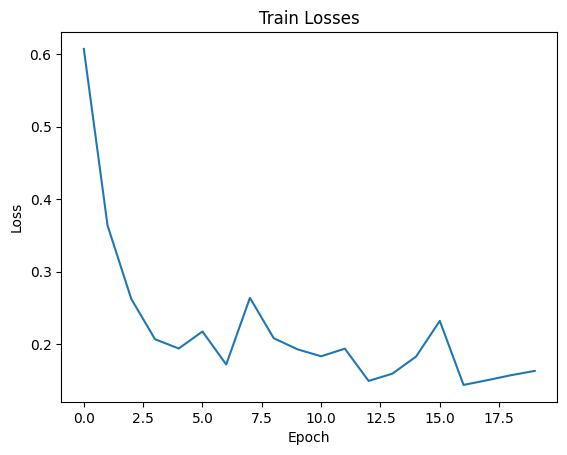

In [46]:
tensor_list = [
    torch.tensor(0.6071, requires_grad=True),
    torch.tensor(0.3636, requires_grad=True),
    torch.tensor(0.2624, requires_grad=True),
    torch.tensor(0.2068, requires_grad=True),
    torch.tensor(0.1940, requires_grad=True),
    torch.tensor(0.2175, requires_grad=True),
    torch.tensor(0.1720, requires_grad=True),
    torch.tensor(0.2639, requires_grad=True),
    torch.tensor(0.2083, requires_grad=True),
    torch.tensor(0.1929, requires_grad=True),
    torch.tensor(0.1833, requires_grad=True),
    torch.tensor(0.1938, requires_grad=True),
    torch.tensor(0.1493, requires_grad=True),
    torch.tensor(0.1593, requires_grad=True),
    torch.tensor(0.1829, requires_grad=True),
    torch.tensor(0.2321, requires_grad=True),
    torch.tensor(0.1438, requires_grad=True),
    torch.tensor(0.1503, requires_grad=True),
    torch.tensor(0.1572, requires_grad=True),
    torch.tensor(0.1631, requires_grad=True)
]

float_list = [t.item() for t in tensor_list]
epochs = list(range(20))
plt.plot(epochs, float_list)
plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim(0, 19)
plt.show()


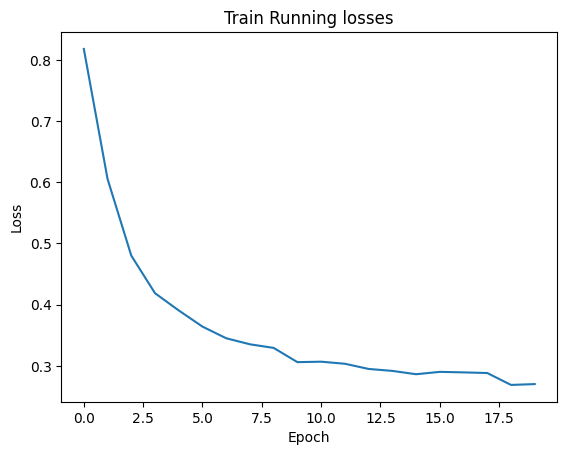

In [42]:
plt.plot(train_running_losses)
plt.title('Train Running losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()